# ipynb for a 2-D CNN for classifying ECGs
Best results found so far used:
    * 3 VCG leads concatenated
    * 200 buffer, 150 shift (looking at QRS -> T lump)
    * Input data chunked into 10000 healthy and 10000 unhealthy samples
    * Peak finder threshold of 0.02 on differentiated and absoluted input data 
    (then it is returned to undiff, unabs data before it is fed in)
    * Trained over 1 epoch.
    * The CNN:
        * Conv with 32 features, map 5x3.
        * 2x2 max pool.
        * Conv 64 features, map 5x3.
        * 2x2 max pool.
        * 1024 neuron dense layer, L2 regularisation with weight_decay=0.001.
        * 1024 neuron dense layer, L2 regularisation with weight_decay=0.001.
        * 50% dropout layer.
        * 2 wide softmax layer.
        * ADAM optimiser with learning_rate=0.00001.
        * Loss function is categorical x-entropy.
        
This gives a result of Sensitivity: 1.0 Specifity: 0.9965 Accuracy: 0.9982 for data taken from the training set (but not trained with).
And Sensitivity: 0.9988 Specifity: 0.9959 Accuracy: 0.9974 on patients it hasn't seen before.

In [1]:
import tensorflow as tf
#import tensorflow.contrib.learn.python.learn as learn
import tflearn 
import scipy as sp
import six
import numpy as np 
import matplotlib.pyplot as plt
from random import shuffle, randint
from sklearn.utils import shuffle as mutualShuf
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_auc_score, roc_curve
import os
import pandas as pd
import sklearn
import datetime
%matplotlib inline

# Import and process data

In [3]:
def importData(filepath):
    ppt = np.genfromtxt(filepath)
    dppt = np.diff(np.transpose(ppt)) 
    print(filepath, "Shape:", dppt[1:16,:].shape)
    return dppt[1:16,:]

pathIll = "./inData/clean_ecg/ill/"
pathHealth = "./inData/clean_ecg/health/"
illLst = []
healthLst = []

for file in os.listdir(pathIll):
    illLst.append(importData(pathIll+file))
for file in os.listdir(pathHealth):
    healthLst.append(importData(pathHealth+file))

./inData/clean_ecg/ill/s0198lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0389lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0411lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0559_re.txt Shape: (15, 120011)
./inData/clean_ecg/ill/s0495_re.txt Shape: (15, 120011)
./inData/clean_ecg/ill/s0339lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0362lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0356lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0409lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0378lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0416lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0348lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0225lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0417lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0375lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0352lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0373lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0235lre.txt Shape: (15, 

In [3]:
frank = True

if frank == False:
    print("Outputting array with shape [12, -1]")
    healthPat = np.concatenate((healthLst[:]), axis=1)[0:12]
    illPat = np.concatenate((illLst[:]), axis=1)[0:12]

elif frank == True:
    print("Outputing Frank leads")
    healthPat = np.concatenate((healthLst[:]), axis=1)[12:15]
    illPat = np.concatenate((illLst[:]), axis=1)[12:15]
    
print(healthPat.shape, illPat.shape)

Outputing Frank leads
(3, 4652605) (3, 3811191)


In [17]:
def findAbove(arr, threshold, skip):
    """
    Return indices for values above threshhold in array, arr. Keep only first items in sequence.
    """
    inlst = []
    for index, item in enumerate(arr):
        if item >= threshold:
            inlst.append(index)
            
    return inlst[::skip]

def processClassData(classData):
    """
    Process classData.
    
    Returns a one-hot array of shape [len(classData), 2].
    """
    # Convert label data to one-hot array
          
    classDataOH = np.zeros((len(classData),2))
    classDataOH[np.arange(len(classData)), classData] = 1
    
    return classDataOH

def getSamples(Arr, indexArr, buffer, shift):
    """
    Get samples for inputting into CNN.
    """
    sampleArr = []

    for index, item in enumerate(indexArr):
        if Arr[0:, item-buffer+shift:item+buffer+shift].shape != (Arr.shape[0], buffer*2):
            pass
        else:
            sampleArr.append(Arr[0:, item-buffer+shift:item+buffer+shift])

    return np.array(sampleArr)

def visualiseData(ecgData, classData, gridSize, axis):
    """
    Plot labelled example data in a gridSize*gridSize grid.
    """
    fig, ax = plt.subplots(gridSize, gridSize)
    plt.suptitle("Labelled example data")
    r = randint(0,len(classData)-ecgData.shape[1])
    k = 0
    for i in np.arange(0,gridSize,1):
        for j in np.arange(0,gridSize,1):
            k = k + 1
            ax[i,j].imshow(ecgData[r+k], cmap='hot', interpolation='nearest')
            if axis == False:
                ax[i,j].axis("off")
            ax[i,j].annotate(classData[r+k], xy=(0, 0), xycoords='axes points',\
                        size=10, ha='left', va='top')

def undiff(ecgData, buffer):
    """
    Reverse the differentiation done earlier through np.cumsum.
    """
    ecgData = np.array(ecgData)
    ecgData = np.reshape(ecgData, (ecgData.shape[0], ecgData.shape[1], buffer*2))
    for i in np.arange(0,ecgData.shape[0],1):
        for j in np.arange(0,ecgData.shape[1],1):
            ecgData[i,j] = np.cumsum(ecgData[i,j])
    ecgData = np.reshape(ecgData, (ecgData.shape[0], ecgData.shape[1], buffer*2, 1))
    return ecgData            
            
def splitData(coilData, classData):
    """
    Split data into healthy and ill types.
    """
    illData = []
    healthData = []
    
    for index, item in enumerate(classData):
        if item == 1:
            illData.append(coilData[index])
        if item == 0:
            healthData.append(coilData[index])
            
    return illData, healthData

def chunkify(lst,n):
    """ Chunk a list into n chunks of approximately equal size """
    return [ lst[i::n] for i in range(n) ]

def functionTownCat(illArr, healthArr, illThreshold, healthThreshold, skip, shift, buffer, shuffle, chunk):
    """
    Return the processed ecgData with the leads concatenated into a 2d array per heartbeat
    and the classData (one-hot). Also return arrays of ill and healthy ppts.
    If shuffle is true, shuffle data. If chunk is true chunk data into 20000 averaged parts.
    """
    
    illPeakArr = findAbove(np.abs(illArr[0]), illThreshold, skip)
    sampleArrI = getSamples(illArr, np.array(illPeakArr), buffer, shift)
    
    healthPeakArr = findAbove(np.abs(healthArr[0]), healthThreshold, skip)
    sampleArrH = getSamples(healthArr, np.array(healthPeakArr), buffer, shift)
    
    if chunk == True:
        chunkyI = chunkify(sampleArrI, 10000)
        chunkyH = chunkify(sampleArrH , 10000)
        avgI = []
        avgH = []
    
        for i in np.arange(0,len(chunkyI),1):
            avgI.append(np.mean(chunkyI[i], axis=0))
        
        for i in np.arange(0,len(chunkyH),1):
            avgH.append(np.mean(chunkyH[i], axis=0))
    
        sampleArrI = np.array(avgI)
        sampleArrH = np.array(avgH)
        
    if chunk == False:
        sampleArrH = sampleArrH[:10000]
        sampleArrI = sampleArrI[:10000]
    
    print("Total ill samples", len(illPeakArr), ". Compressed to", sampleArrI.shape)
    print("Total healthy samples", len(healthPeakArr), ". Compressed to", sampleArrH.shape)
    
    classData = []
    for i in np.arange(0, sampleArrI.shape[0], 1):
        classData.append(1)
    for i in np.arange(0, sampleArrH.shape[0], 1):
        classData.append(0)
    ecgData = np.concatenate((sampleArrI, sampleArrH), axis=0)
                        
    if shuffle == True:
        classData, ecgData = mutualShuf(np.array(classData), ecgData, random_state=0)    
    
    classDataOH = processClassData(classData)
    ecgData = np.reshape(ecgData, [-1, sampleArrI.shape[1], buffer*2, 1])
    return ecgData, classDataOH, classData

buffer = 200
healthThreshold = 0.02
illThreshold = 0.02
skip = 1
shift = 150
shuf = True

ecgData, classDataOH, classData = functionTownCat(illPat, healthPat, illThreshold, healthThreshold, skip,\
                                               shift, buffer, shuf, True)
# Reintegrate the found values...
ecgData = undiff(ecgData, buffer)

# Normalise:
#ecgData = np.reshape(ecgData, ecgData.shape[0:3])
#for index, item in enumerate(ecgData):
#    ecgData[index] = normalize(item, axis=1)
#ecgData = ecgData[...,np.newaxis]
  
# Take 20% for testing later:
testData = ecgData[:round(ecgData.shape[0]*0.2)]
trainData = ecgData[round(ecgData.shape[0]*0.2):]
testLabels = classDataOH[:round(ecgData.shape[0]*0.2)]
trainLabels = classDataOH[round(ecgData.shape[0]*0.2):]

Total ill samples 180028 . Compressed to (10000, 3, 400)
Total healthy samples 215821 . Compressed to (10000, 3, 400)


(20000, 3, 400, 1)


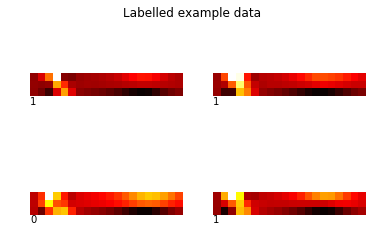

In [19]:
print(ecgData.shape)
#plt.plot(ecgData[0][0])
visualiseData(np.reshape(ecgData,(-1,ecgData.shape[1],buffer*2))[:,:,::20], classData, 2, False)
#plt.savefig("../thesis/images/ecg2d.pdf")

# Neural Network

In [20]:
sess = tf.InteractiveSession()
tf.reset_default_graph()
tflearn.initializations.normal()

#ecgData = np.zeros((50,3,400,1)) # If ecgData is not defined
# Input layer:
net = tflearn.layers.core.input_data(shape=[None, ecgData.shape[1], buffer*2, 1])

# First layer:
net = tflearn.layers.conv.conv_2d(net, 32, [3,25], activation="leaky_relu")
net = tflearn.layers.conv.max_pool_2d(net, 2, strides=2)

# Second layer:
net = tflearn.layers.conv.conv_2d(net, 64, [3,25], activation="leaky_relu")
net = tflearn.layers.conv.max_pool_2d(net, 2, strides=2)

# Fully connected layer 1:
net = tflearn.layers.core.fully_connected(net, 1024, regularizer="L2", weight_decay=0.001, activation="leaky_relu")
net = tflearn.layers.core.fully_connected(net, 1024, regularizer="L2", weight_decay=0.001, activation="leaky_relu")

# Dropout layer:
net = tflearn.layers.core.dropout(net, keep_prob=0.5)

# Output layer:
net = tflearn.layers.core.fully_connected(net, 2, activation="softmax")

net = tflearn.layers.estimator.regression(net, optimizer='adam', loss='categorical_crossentropy',\
                         learning_rate=0.00001)

In [21]:
model = tflearn.DNN(net, tensorboard_verbose=0)
model.fit(trainData, trainLabels, n_epoch=1, show_metric=True)

Training Step: 249  | total loss: 0.03450 | time: 215.082s
| Adam | epoch: 001 | loss: 0.03450 - acc: 0.9998 -- iter: 15936/16000
Training Step: 250  | total loss: 0.03468 | time: 215.937s
| Adam | epoch: 001 | loss: 0.03468 - acc: 0.9999 -- iter: 16000/16000
--


In [22]:
# Save model?
#now = datetime.datetime.now()
model.save("/tmp/1")
#model.load("/tmp/1")

INFO:tensorflow:/tmp/1 is not in all_model_checkpoint_paths. Manually adding it.


# Test accuracy of model(s)
## 20% of training data held back for testing (4000 "heartbeats")

In [23]:
#model.load("./saved1.tflearn")
#model.load("./outData/models/cleanECG_undiff_20e_300buff_0shift_2017-02-21T19:20:35.702943_.tflearn")
#model.load("./outData/models/cleanECG_undiff_20e_150buff_2017-02-21T16:15:02.602923_.tflearn")
#model.load("./outData/models/cleanECG_2dconv_12lead_2017-03-08T10:15:17.200943_.tflearn")
#model.load("./outData/models/cleanECG_2dconv_12lead_2017-03-09T18:05:18.655939_.tflearn")

In [24]:
labellst = classData[:round(ecgData.shape[0]*0.2)]
healthTest = []
illTest = []
for index, item in enumerate(labellst):
    if item == 1:
        illTest.append(testData[index])
    if item == 0:
        healthTest.append(testData[index])

healthLabel = np.tile([1,0], (len(healthTest), 1))
illLabel = np.tile([0,1], (len(illTest), 1))

predicted = np.array(model.predict(testData))

print("Sensitivity:", model.evaluate(np.array(healthTest), healthLabel), "Specifity:",\
    model.evaluate(np.array(illTest), illLabel),\
    "Accuracy:", model.evaluate(testData, testLabels),\
     "AUC:", roc_auc_score(labellst, predicted[:,1]))

Sensitivity: [1.0] Specifity: [0.99749247743229685] Accuracy: [0.99875000000000003] AUC: 0.999998249984


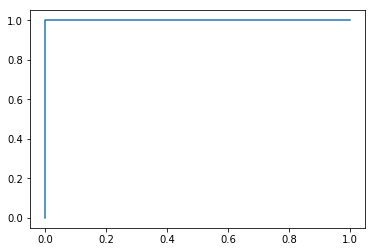

In [25]:
plt.plot(roc_curve(labellst, predicted[:,1])[0], roc_curve(labellst, predicted[:,1])[1])

## What do the filters look like?

In [24]:
def display_convolutions(model, layer, padding=4, filename=''):
    """
    Taken from smistad @ https://github.com/tflearn/tflearn/issues/291.
    """
    if isinstance(layer, six.string_types):
        vars = tflearn.get_layer_variables_by_name(layer)
        variable = vars[0]
    else:
        variable = layer.W

    data = model.get_weights(variable)

    # N is the total number of convolutions
    N = data.shape[2] * data.shape[3]
    print(data.shape)

    # Ensure the resulting image is square
    filters_per_row = int(np.ceil(np.sqrt(N)))
    # Assume the filters are square
    filter_size = data.shape[0], data.shape[1]
    # Size of the result image including padding
    result_size = filters_per_row * (filter_size[0] + padding) - padding, \
                    filters_per_row * (filter_size[1] + padding) - padding
    # Initialize result image to all zeros
    result = np.zeros((result_size[0], result_size[1]))

    # Tile the filters into the result image
    filter_x = 0
    filter_y = 0
    for n in range(data.shape[3]):
        for c in range(data.shape[2]):
            if filter_x == filters_per_row:
                filter_y += 1
                filter_x = 0
            for i in range(filter_size[0]):
                for j in range(filter_size[1]):
                    result[filter_y * (filter_size[0] + padding) + i, filter_x * (filter_size[1] + padding) + j] = \
                        data[i, j, c, n]
            filter_x += 1

    # Normalize image to 0-1
    min = result.min()
    max = result.max()
    result = (result - min) / (max - min)

    # Plot figure
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(result, cmap='gray', interpolation='nearest')

    # Save plot if filename is set
    if filename != '':
        plt.savefig(filename, bbox_inches='tight', pad_inches=0)

    plt.show()

(3, 25, 1, 32)


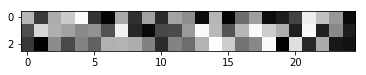

In [26]:
var2 = net0.W
data1 = model.get_weights(var2)
print(data1.shape)
data1 = data1.reshape((3,25,32))
plt.imshow(data1[:,:,1], cmap='gray', interpolation='nearest')

(3, 25, 1, 32)


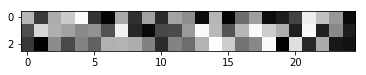

In [27]:
var2 = net0.W
data1 = model.get_weights(var2)
print(data1.shape)
data1 = data1.reshape((3,25,32))
plt.imshow(data1[:,:,1], cmap='gray', interpolation='nearest')

(3, 25, 1, 32)


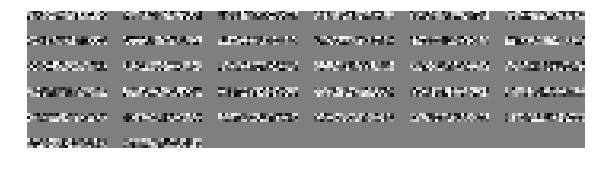

In [28]:
display_convolutions(model, net0, padding=5, filename='')

(3, 25, 32, 64)


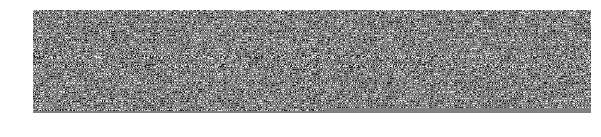

In [29]:
display_convolutions(model, net2, padding=2, filename='')

## What if the model hasn't seen data from the patient?

In [26]:
tpathIll = "./inData/clean_ecg/testIll/"
tpathHealth = "./inData/clean_ecg/testHealth/"
tillLst = []
thealthLst = []

for file in os.listdir(tpathIll):
    tillLst.append(importData(tpathIll+file))
for file in os.listdir(tpathHealth):
    thealthLst.append(importData(tpathHealth+file))

./inData/clean_ecg/testIll/s0177lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0044lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0088lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0219lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0215lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0174lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0314lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0145lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0133lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0185lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0080lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0124lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0100lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0119lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0131lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0127lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0095lre.txt 

In [27]:
if frank == False:
    print("Outputing standard ECG leads...")
    thealth = np.concatenate((thealthLst[:]), axis=1)[0:12]
    till = np.concatenate((tillLst[:]), axis=1)[0:12]

elif frank == True:
    print("Outputing Frank leads...")
    thealth = np.concatenate((thealthLst[:]), axis=1)[12:15]
    till = np.concatenate((tillLst[:]), axis=1)[12:15]
    
print(thealth.shape, till.shape)

Outputing Frank leads...
(3, 4788699) (3, 3718367)


In [28]:
unseenData, unseenClassOH, unseenClass = functionTownCat(till, thealth, illThreshold, healthThreshold, \
                                                   skip, shift, buffer, True, True)

# Normalise:
#unseenData = np.reshape(unseenData, unseenData.shape[0:3])
#for index, item in enumerate(unseenData):
#    unseenData[index] = normalize(item, axis=1)
#unseenData = unseenData[...,np.newaxis]

Total ill samples 162516 . Compressed to (10000, 3, 400)
Total healthy samples 236811 . Compressed to (10000, 3, 400)


In [29]:
# Undifferentiate values
unseenData = undiff(unseenData, buffer)
tillarr, thealtharr = splitData(unseenData, unseenClass)

In [ ]:
sens = model.evaluate(np.array(thealtharr), np.tile([1,0], (len(thealtharr), 1)))[0]
spec = model.evaluate(np.array(tillarr), np.tile([0,1], (len(tillarr), 1)))[0]
acc = model.evaluate(unseenData, unseenClassOH)[0]
lenh = len(thealtharr)
leni = len(tillarr)
predicted2 = model.predict(unseenData)

print("Sensitivity:", sens,\
      "Specifity:", spec,\
      "Accuracy:", acc)

In [ ]:
plt.plot(roc_curve(unseenClass, np.array(predicted2)[:,1])[0], roc_curve(unseenClass, np.array(predicted2)[:,1])[1])

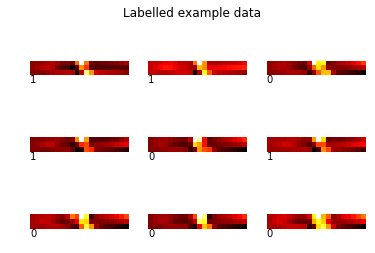

In [16]:
visualiseData(np.reshape(unseenData,(-1,unseenData.shape[1],buffer*2))[:,:,::20], unseenClass, 3, False)